# Image Processing Pipeline

Here we'll explore the image processing pipeline step-by-step. 

We'll see how the MDI and HMI solar images are mapped onto an equal area space, how the sunspot features are extracted, how those sunspots are labeled against an exisitng data set, and finally saved to a database. 

In [ ]:
# Import Python Libraries 
import os
from astropy.io import fits
from math import pi, sin, cos, sqrt, atan2
from time import time
import numpy as np
import pandas as pd
from astropy.convolution import convolve_fft, convolve
import astropy.convolution
import matplotlib.pyplot as plt
import cPickle
%matplotlib inline

# Import user defined modules 
from Cylindrical_Map_Transformation import get_header_params_MDI, map_disk_cylindric
import sunspot_feature_extraction
import extract_features_script
import Centroid_Labeling
import extract_image_features

### 1st Half of Pipeline
    The 1st half of the pipeline lends itself to many visuals. 
    Here, we load and map the image into equal area cylindrical space. 
    Next, we convolve the image through Fast Fourier Transformation. 
    Then, we identify the distinct active regions, label them, and seperate them from the background. 

#### Import Images

In [2]:
# navagate to image location
image_path = "/Users/Alexander/NASA/NASA_Sample_Data/Images/"
# load file names
file_names = []
for filename in os.listdir(image_path):
    if "ds_store" not in filename.lower():
        file_names.append(filename)       

In [18]:
file_name = file_names[0]
file_name

'fd_M_96m_01d.3925.0000.fits'

In [19]:
mdi_path = image_path +file_name

First, let's take a look at the MDI meta-data. The meta-data tells us when the image was taken, the size of the image, the tilt of the SOHO satellite, as well as the tilt of the sun relative to the earth. 

In [5]:
hdulist_mdi =  fits.open(mdi_path)
hud_mdi =  hdulist_mdi[0]
hud_mdi.header

SIMPLE  =                    T / file conforms with FITS standard; SOI V6R1B0   
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 1024                                                  
NAXIS2  =                 1024                                                  
COMMENT Data from the Solar Oscillations Investigation / Michelson Doppler      
COMMENT   Imager (SOI/MDI) on the Solar and Heliospheric Observatory (SOHO).    
COMMENT For information on data rights, keyword definitions, and up-to-date     
COMMENT   reports on known problems and data quality, see:                      
COMMENT   http://soi.stanford.edu/data.html                                     
HISTORY created by mdical Tue Oct  7 13:54:41 2003                              
HISTORY created by MDI_image_reconstructor Wed Oct  8 12:55:16 2003             
HISTORY An MDI magnetogram z

#### Clean Data

In [6]:
df_mdi = pd.DataFrame(hud_mdi.data)
df_mdi.fillna(value=0,inplace=True)
clean_data_mdi = df_mdi.values

### Map Image into Equal Area Cylindrical Space
    In order to map the image into a different space, we need to get some parameters from the header. These parameters related to the spatial orientation of the image, the tilte of the sun and other physical vlaues. 

In [7]:
# extract parameters from header
xCen,yCen,s0,nx,pixsize,p0,b0, r0 = get_header_params_MDI(hud_mdi.header)

In [8]:
# transform data into cylindrical equal area map
start = time()
trans_data_mdi = map_disk_cylindric(xCen,yCen,s0,nx,pixsize,p0,b0, r0, clean_data_mdi)
end = time()
print "Time Elapsed = {:.4} secs".format(end - start)

Time Elapsed = 21.41 secs


#### Image Before Mapping

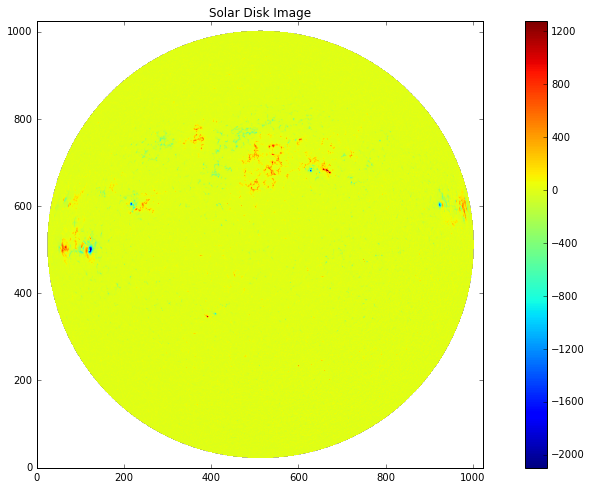

In [9]:
plt.figure(figsize = (15,8));
a1 = np.ma.masked_where(clean_data_mdi == 0.0, clean_data_mdi)
plt.imshow(a1, origin='lower');
plt.title("Solar Disk Image")
plt.colorbar()
plt.show()

#### Equal Area Cylindrical Transformation 

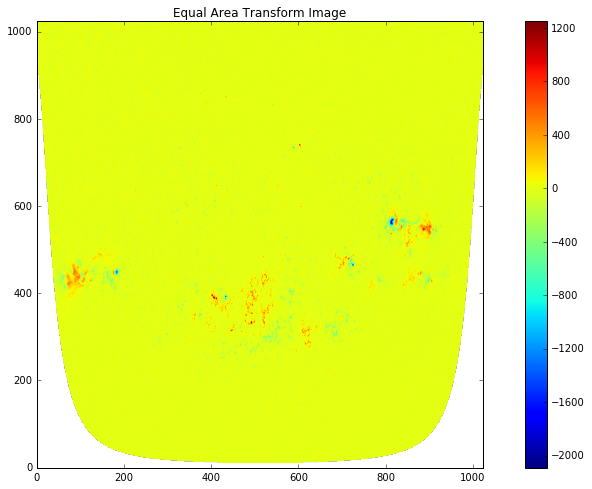

In [10]:
plt.figure(figsize = (15,8));
a2 = np.ma.masked_where(trans_data_mdi == 0.0, trans_data_mdi)
plt.imshow(a2, origin='lower')
plt.title("Equal Area Transform Image")
plt.colorbar()
plt.show()

The reason why we want to transform the image into an equal area space is due to the physics of magnetism. 
Magnetic flux is the amount of magnetism that passes through a unit area. The orignal image's surface area is not normalized. So a patch of image near the sun's equator has more area than that same patch near one of the sun's poles. This mapping normalizes the image so that each pixel represents the same amount of surface area. 

### Find Active Regions of Magnetic Fields

Active Regions are regions of the sun's surface with intense magnetic activity. These regions usually have sunspots and each active regions usually has a pair of sunspots, one sunspot with positive magnetic polarity and one with negative mangetic polarity. 


In order to identify the active regions:
    1. Take abs of data, the signs doesn't matter
    2. Smooth the data with smoothing Kernal
    3. Apply Convolution with Fourier Transforms 
    
    
    

In [11]:
data_abs_mdi = np.abs(trans_data_mdi)
param = 8
gauss = astropy.convolution.Gaussian2DKernel(stddev=param)
gauss_data_mdi = convolve_fft(data_abs_mdi, gauss)

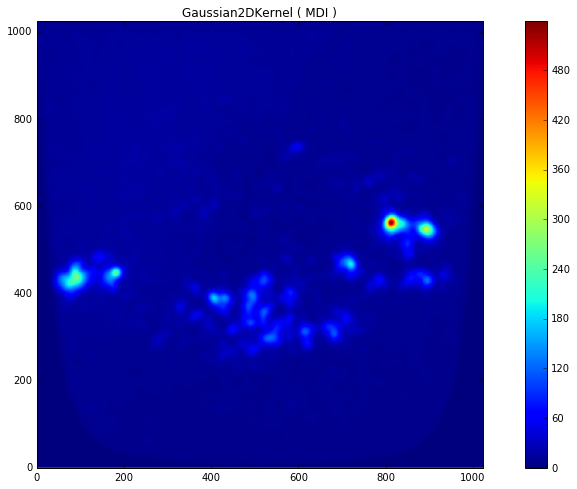

In [12]:
plt.figure(figsize = (15,8));
plt.imshow(gauss_data_mdi, interpolation='none', origin='lower');
plt.title("Gaussian2DKernel ( MDI )")
plt.colorbar()
# plt.xlim(x_limits_mdi)
# plt.ylim(y_limits_mdi)
# plt.xlim((200,450))
# plt.ylim((200,450))
plt.show()

### Active Region Mask 
Now that we have identifed the active regions by the intensity of their magnetic flux, we need to seperate them from the background. 
     
    1. Experimentally set a flux threshold value
    2. Filter out portions of the image with flux below this value
    3. Create mask will allow us to hot-encode a matrix of 0's and 1's. 

In [13]:
def get_active_region_mask(convolved_image, trans_image, flux_thresh ):
    convolved_image_copy = convolved_image.copy()
    # one-hot encode image based on flux threshold value
    convolved_image_copy[convolved_image_copy < flux_thresh] = 0.
    convolved_image_copy[convolved_image_copy >= flux_thresh] = 1 
    # filter original image with active region map 
    return  np.where(convolved_image_copy !=0.0 , trans_image, convolved_image_copy)

In [14]:
flux_thresh_mdi = 120 # <-- use as offical cut off value for MDI 
active_region_image = get_active_region_mask(gauss_data_mdi, trans_data_mdi, flux_thresh_mdi )

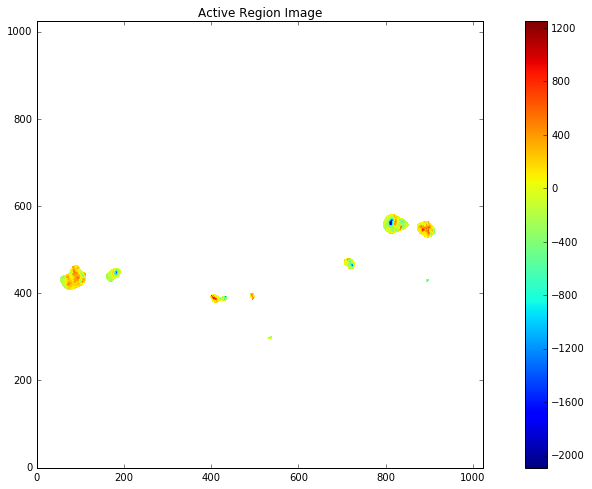

In [15]:
plt.figure(figsize = (15,8));
test_plot  = np.ma.masked_where(active_region_image == 0.0, active_region_image)
plt.imshow(test_plot, interpolation='none', origin='lower');
plt.title("Active Region Image")
plt.colorbar()
# plt.xlim((100,700))
# plt.ylim((650,850))
plt.show()

The image above has been cropped to only include the two active regions of this image. In the dark blue, convolved image we can see that there appears to be more active regions in the lower left quadrent. The flux threshold is adjusted to not include those regions. Those regions appear to be the beginnings (or endding) of sunspot formation. If those regions are the beginnings of sunspots with intense flux, then an image taken at a latter time will capture them. 

### Extract Feautres from Sunspots
Here, we apply some basic physical equations that identify the average position and total magnetic flux of each sunspots. 

The code below performs all the above operations (mapping image, identify active regions) as well as extracts the sunspot features. 

In [16]:
reload(extract_features_script)

<module 'extract_features_script' from 'extract_features_script.pyc'>

In [20]:
start = time()
new_feat_objects = extract_features_script.extract_features_from_images(image_path, file_name)
end = time()
print "Time Elapsed = {}".format(end - start)

get active region map...
identify active regions in image for file
extract features from image
Time Elapsed = 286.189208984


In [21]:
new_feat_objects

{0: (0, 0),
 1: {'lat_neg': -13.86,
  'lat_pos': -13.99,
  'long_neg': 282.98,
  'long_pos': 278.97,
  'neg_net_flux': -44000.63,
  'pos_net_flux': 611621.86,
  'x_neg_ave': 430.36,
  'x_pos_ave': 407.57,
  'y_neg_ave': 389.34,
  'y_pos_ave': 388.22},
 3: {'lat_neg': -8.82,
  'lat_pos': -8.8,
  'long_neg': 220.7,
  'long_pos': 222.54,
  'neg_net_flux': -87026.47,
  'pos_net_flux': 3625978.37,
  'x_neg_ave': 76.07,
  'x_pos_ave': 86.53,
  'y_neg_ave': 433.45,
  'y_pos_ave': 433.66},
 4: {'lat_neg': -7.69,
  'lat_pos': -7.28,
  'long_neg': 238.41,
  'long_pos': 238.02,
  'neg_net_flux': -154612.9,
  'pos_net_flux': 176487.65,
  'x_neg_ave': 176.83,
  'x_pos_ave': 174.59,
  'y_neg_ave': 443.45,
  'y_pos_ave': 447.04},
 5: {'lat_neg': -5.1,
  'lat_pos': -4.16,
  'long_neg': 333.95,
  'long_pos': 332.78,
  'neg_net_flux': -89797.4,
  'pos_net_flux': 162964.33,
  'x_neg_ave': 720.31,
  'x_pos_ave': 713.68,
  'y_neg_ave': 466.44,
  'y_pos_ave': 474.79},
 6: {'lat_neg': 3.33,
  'lat_pos': 3.96

### 2nd Half of Pipeline
    This portion of the pipeline does not have any visuals to aid explanation. 
    Here, we compare active region centroids between my image data and noaa data
    in order to identify pairs and label my active regions with noaa active region labels. 
    Next, we pass the pairs through a couple of filters to make sure that redundent pairs 
    weren't assigned, then save to file. 
    
    
    Nornally, the function filter_label_saveToFile is called the handle the 2nd portion of the
    pipeline. However for clarity, I've unpacked filter_label_saveToFile so that you can see
    which functions calls are included. 

In [22]:
noaa_home = "/Users/Alexander/NASA/noaa_data/"
noaa_data = extract_features_script.load_noaa_data(noaa_home)

In [57]:
db_path = "/Users/Alexander/NASA/Database/"
extract_features_script.filter_label_saveToFile(new_feat_objects, db_path, noaa_data)

running get_noaa_and_image_centroids...
running get_shortest_distance_pair...
running check_repeating_noaa_assignments...
running filter_extra_active_region_assignments...
running save_features_to_file...


In [61]:
# Assinge extracted AR to NOAA AR if dist between any 2 is less than 5 degrees
# this will return one-to-many parings, if they exist 
print "running get_shortest_distance_pair..."
shortest_dist_pairs = extract_image_features.get_shortest_distance_pair(my_cents, noaa_cents_labels)

running get_shortest_distance_pair...


In [62]:
# returns one-to-one pairs with the shortest distance between them
# {noaa_ar: [{Image_ar : dist}]
print "running check_repeating_noaa_assignments..."
clean_ar_assignments = extract_image_features.check_repeating_noaa_assignments(shortest_dist_pairs)

running check_repeating_noaa_assignments...


In [64]:
print "running filter_extra_active_region_assignments..."
clean_feat_object = Centroid_Labeling.filter_extra_active_region_assignments(new_feat_objects, 
                                                                             clean_ar_assignments)

running filter_extra_active_region_assignments...


In [66]:
#return my_cents, noaa_cents, shortest_dist_pairs, clean_ar_assignments, clean_feat_object
print "running save_features_to_file..."
Centroid_Labeling.save_features_to_file(db_path, clean_feat_object)

running save_features_to_file...


### View Results

In [58]:
results_path = db_path + "features_mdi.txt"

In [59]:
feats_df = pd.read_csv(results_path, delimiter='\t')

In [60]:
feats_df.head()

,YYYY_MM_DD,hh:mm:ss,AR,Flux,Longitude,Latitude
0,2003 10 01,00:03:03,10470P,611621.86,278.97,-13.99
1,2003 10 01,00:03:03,10470N,-44000.63,282.98,-13.86
2,2003 10 01,00:03:03,10471P,3625978.37,222.54,-8.80
3,2003 10 01,00:03:03,10471N,-87026.47,220.70,-8.82
4,2003 10 01,00:03:03,10466P,176487.65,238.02,-7.28
